In [7]:
# Packages
import random
from PIL import Image
from pathlib import Path

In [10]:
image_path = Path("/Users/alextsagkas/Document/Office/solar_panels/data/")
image_path_list = list(image_path.glob("*/*/*.jpg"))

[PosixPath('/Users/alextsagkas/Document/Office/solar_panels/data/test/soiled/solar_Fri_Jun_23_14__19__5_2017_L_0.827614612578_I_0.233266666667.jpg'), PosixPath('/Users/alextsagkas/Document/Office/solar_panels/data/test/soiled/solar_Thu_Jun_15_6__41__5_2017_L_0.0644250045562_I_0.0430352941176.jpg'), PosixPath('/Users/alextsagkas/Document/Office/solar_panels/data/test/soiled/solar_Thu_Jun_29_11__29__9_2017_L_0.659890646955_I_0.513537254902.jpg')]


In [91]:
image_path_list[0].parents[3]

PosixPath('/Users/alextsagkas/Document/Office/solar_panels')

In [11]:
print(image_path_list[:3])

[PosixPath('/Users/alextsagkas/Document/Office/solar_panels/data/test/soiled/solar_Fri_Jun_23_14__19__5_2017_L_0.827614612578_I_0.233266666667.jpg'), PosixPath('/Users/alextsagkas/Document/Office/solar_panels/data/test/soiled/solar_Thu_Jun_15_6__41__5_2017_L_0.0644250045562_I_0.0430352941176.jpg'), PosixPath('/Users/alextsagkas/Document/Office/solar_panels/data/test/soiled/solar_Thu_Jun_29_11__29__9_2017_L_0.659890646955_I_0.513537254902.jpg')]


Random image path: /Users/alextsagkas/Document/Office/solar_panels/data/train/clean/solar_Tue_Jun_27_17__30__52_2017_L_0.0475258477641_I_0.092168627451.jpg
Random image class: clean
Image height: 192
Image width: 192


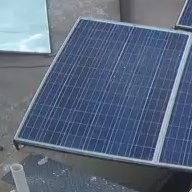

In [28]:
# Get a random image and its class

# random.seed(42)

random_image = random.choice(image_path_list)
random_image_class = random_image.parent.name

img = Image.open(random_image)

print(f"Random image path: {random_image}")
print(f"Random image class: {random_image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [33]:
# Transform the images
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [34]:
import torch.backends.mps

# Device agnostic code
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")

Using device: mps


In [35]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

print(data_transform)

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


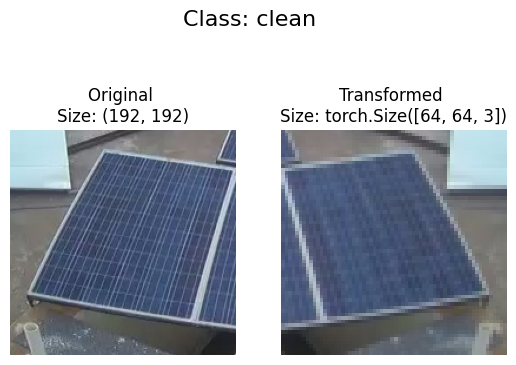

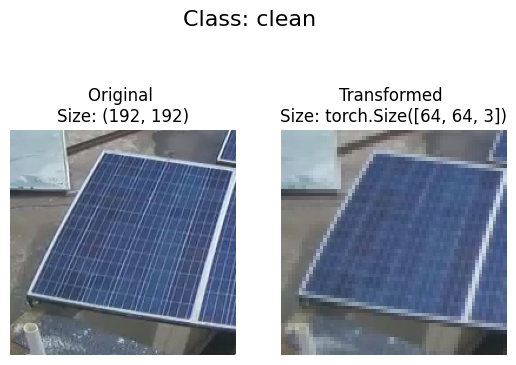

In [86]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=2)

In [42]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_data = datasets.ImageFolder(root=str(train_dir), # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=str(test_dir), 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 36533
    Root location: /Users/alextsagkas/Document/Office/solar_panels/data/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 9132
    Root location: /Users/alextsagkas/Document/Office/solar_panels/data/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [44]:
class_names = train_data.classes
class_dict = train_data.class_to_idx

print(f"Class names: {class_names}, Class dict: {class_dict}")

Class names: ['clean', 'soiled'], Class dict: {'clean': 0, 'soiled': 1}


Text(0.5, 1.0, 'Test image: clean')

<Figure size 1000x1000 with 0 Axes>

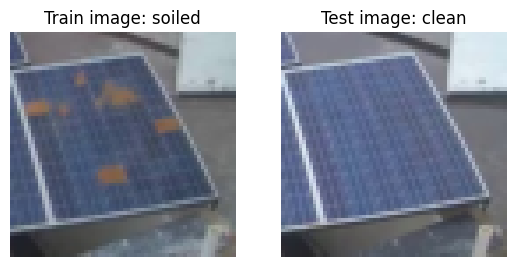

In [78]:
# See first image from test and train data

train_image_first, train_label_first = train_data[13175]
test_image_first, test_label_first = test_data[2]

plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(1,2)

ax[0].imshow(train_image_first.permute(1, 2, 0))
ax[0].axis(False)
ax[0].set_title(f"Train image: {class_names[train_label_first]}")

ax[1].imshow(test_image_first.permute(1, 2, 0))
ax[1].axis(False)
ax[1].set_title(f"Test image: {class_names[test_label_first]}")

In [80]:
# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x17ea95b80>,
 <torch.utils.data.dataloader.DataLoader at 0x17ef47340>)

In [81]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])
